# **Clustering Images**

The objective is to partition the given images from dataset1 into different Clusters.

1.   Load the images
2.   Pre process the images.
3.   Apply a pre trained neural Network to extract feature vectors.
4.   Apply PCA for dimensionality reduction of the features.
5. Apply K-means algorithm to extract the cluster of images


Import the modules needed in order to load/process the images along with the modules to extract and cluster the feature vectors.

In [ ]:
import keras
# for loading/processing the images  
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 

# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# For plotting and saving the model
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
!unzip -q "/content/gdrive/My Drive/dataset1.zip"

In [ ]:
print(len(os.listdir('/content/dataset1')))


1000


(1440, 1080, 3)


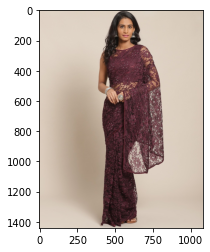

In [ ]:
#have a look at the first image
img=load_img('/content/dataset1/84010.jpg')
img = np.array(img)
print(img.shape)
plt.imshow(img)

In [ ]:
path='/content/dataset1/'
os.chdir(path)

# this list holds all the image filename
image_data = []

# creates a ScandirIterator aliased as files
with os.scandir(path) as files:
  # loops through each file in the directory
    for file in files:
        image_data.append(file.name)

In [ ]:
image_data[0:4]

['84791.jpg', '84179.jpg', '84603.jpg', '84581.jpg']

In [ ]:
# load model and remove the last layer
model = VGG16()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

553467904/553467096 [==============================] - 4s 0us/step


In [ ]:
#for one image
img = load_img(image_data[0], target_size=(224,224))
# convert from 'PIL.Image.Image' to numpy array
img = np.array(img)
print(img.shape)
reshaped_img = img.reshape(1,224,224,3)
print(reshaped_img.shape)
x = preprocess_input(reshaped_img)
#for 1 image
features = model.predict(x)
print(features.shape)


(224, 224, 3)
(1, 224, 224, 3)
(1, 4096)


extract_features function returns the features. Images are resized to 224 by 224 as VGG16 accepts only this size. Keras. preprocessing library is used to preprocess the images.

In [ ]:
def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

Save the features in a Pickle file and can be loaded when it is required.

In [ ]:
data = {}

p='/content/data_features.pkl'
# lop through each image in the dataset
for image in image_data:
    # try to extract the features and update the dictionary
    try:
        feat = extract_features(image,model)
        data[image] = feat
    # if something fails, save the extracted features as a pickle file (optional)
    except:
        with open(p,'wb') as file:
            pickle.dump(data,file)
          
 
# get a list of the filenames
filenames = np.array(list(data.keys()))

# get a list of just the features
feat = np.array(list(data.values()))
print(feat.shape)


# reshape so that there are 1000 samples of 4096 vectors
feat = feat.reshape(-1,4096)
print(feat.shape)

(1000, 1, 4096)
(1000, 4096)


Apply Pricipal Component Analysis on the features and get the reduced dimension

In [ ]:
pca = PCA(n_components=500, random_state=22)
pca.fit(feat)
x1 = pca.transform(feat)
print(x1.shape)

(1000, 500)


Apply KMeans algoritm to get the clusters as the data set is unlabelled.
Suitable no_of_clusters can be found from the elbow curve. 

In [ ]:
no_of_clusters=list(np.arange(200))
kmeans = KMeans(n_clusters=len(no_of_clusters),n_jobs=-1, random_state=22)
kmeans.fit(x1)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=200, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=22, tol=0.0001, verbose=0)

In [ ]:
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [ ]:
# function that lets to view a cluster (based on identifier)        
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > 30:
        print(f"Clipping cluster size from {len(files)} to 30")
        files = files[:29]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

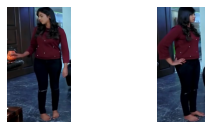

In [ ]:
view_cluster(0)

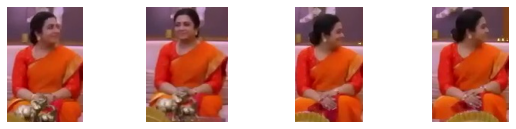

In [ ]:
view_cluster(144)

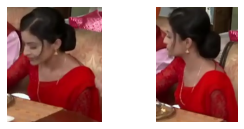

In [ ]:
view_cluster(199)

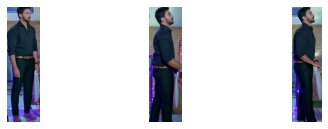

In [ ]:
view_cluster(150)


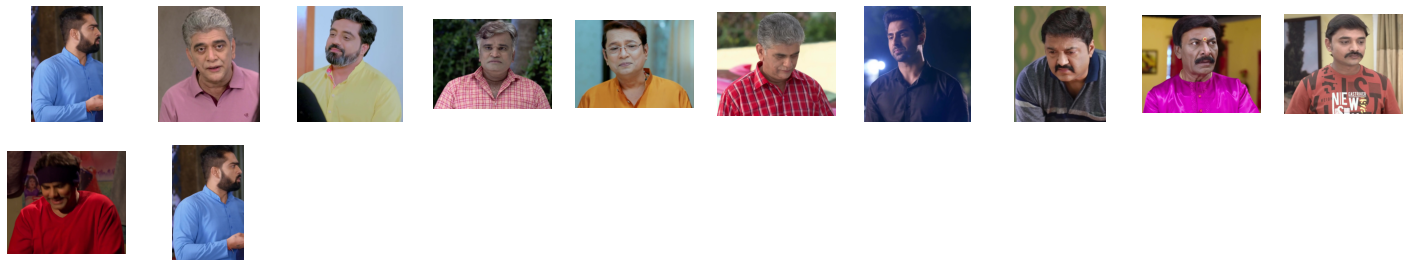

In [ ]:
view_cluster(1)

From the Elbow curve below we can observe that the curve keeps going down as the cluster size is getting increased. 

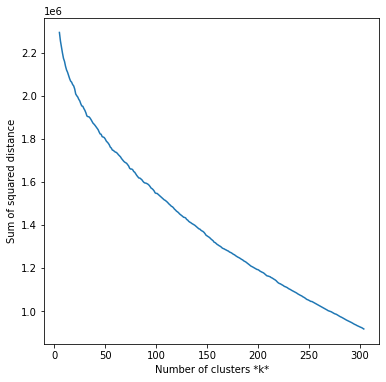

In [ ]:
# this is just incase you want to see which value for k might be the best 
sse = []
list_k = list(range(5, 305))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=22, n_jobs=-1)
    km.fit(x1)
    
    sse.append(km.inertia_)
# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse)
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

**Conclusion:**

Clusters are derived from the data.It is obvious from the elbow curve choosing the optimum no of clusters is difficult. 

In [ ]:
# Can try for Agglomerative or Divisive clustering